LinearRegression: RMS_RA = 0.000068 deg, RMS_DEC = 0.000104 deg
Ridge: RMS_RA = 0.000067 deg, RMS_DEC = 0.000104 deg
RandomForest: RMS_RA = 0.015086 deg, RMS_DEC = 0.010602 deg


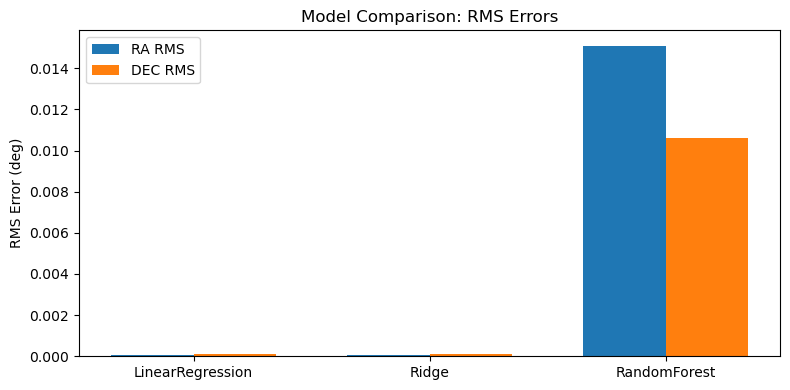


Best model overall: Ridge
Predicted RA2000: 00 43 53.11, DEC2000: +41 26 21.47


In [3]:
# Jupyter Notebook: Pixel-to-RA/DEC Transformation Fitting
# Author: Yash
# Date: 2025-07-06

# 1. Import required libraries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 2. Define helper functions to parse and format RA/DEC

def ra_to_deg(ra_str):
    '''Convert RA string "HH MM SS.SS" to decimal degrees.'''
    h, m, s = [float(x) for x in ra_str.split()]
    return (h + m/60 + s/3600) * 15


def dec_to_deg(dec_str):
    '''Convert DEC string "+DD MM SS.SS" to decimal degrees.'''
    sign = 1 if dec_str.strip().startswith('+') else -1
    parts = dec_str.strip().lstrip('+-').split()
    d, m, s = [float(x) for x in parts]
    return sign * (d + m/60 + s/3600)


def deg_to_ra(ra_deg):
    '''Convert decimal degrees to RA string "HH MM SS.SS".'''
    total_hours = ra_deg / 15.0
    h = int(total_hours)
    m = int((total_hours - h) * 60)
    s = (total_hours - h - m/60) * 3600
    return f"{h:02d} {m:02d} {s:05.2f}"


def deg_to_dec(dec_deg):
    '''Convert decimal degrees to DEC string "+DD MM SS.SS".'''
    sign = '+' if dec_deg >= 0 else '-'
    dec_deg = abs(dec_deg)
    d = int(dec_deg)
    m = int((dec_deg - d) * 60)
    s = (dec_deg - d - m/60) * 3600
    return f"{sign}{d:02d} {m:02d} {s:05.2f}"

# 3. Load and preprocess the data
csv_data = '''PXL-X,PXL-Y,RA,DEC
2081.99,1818.62,00 42 38.71,+41 20 21.2
2176.01,1844.19,00 42 29.69,+41 19 53.3
2281.65,1865.58,00 42 19.57,+41 19 29.7
2298.55,1914.03,00 42 18.02,+41 18 37.2
2301.69,1969.2,00 42 17.74,+41 17 37.7
2270.28,1988.29,00 42 20.75,+41 17 17.2
2234.3,2026.75,00 42 24.20,+41 16 36.1
2176.07,1951.3,00 42 29.74,+41 17 58.0
2206.05,2208.38,00 42 27.00,+41 13 20.0
2159.16,2192.94,00 42 31.48,+41 13 37.0
2125.91,2108.12,00 42 34.56,+41 15 08.6
2185.69,2324.12,00 42 29.02,+41 11 15.3
2036.23,2281.11,00 42 43.29,+41 12 02.5
1997.32,2275.69,00 42 47.01,+41 12 08.5
2022.78,2133.73,00 42 44.44,+41 14 41.4
1890.52,2217.86,00 42 57.19,+41 13 11.5
1877.67,2162.02,00 42 58.42,+41 14 11.8
1861.45,2132.27,00 42 59.95,+41 14 43.9
1790.57,2105.25,00 43 06.72,+41 15 13.2
1885.71,1969.86,00 42 57.58,+41 17 40.1
1852.01,1963.14,00 43 00.79,+41 17 46.5
1819.78,1946.18,00 43 03.88,+41 18 05.0
1788.47,1866.78,00 43 06.85,+41 19 30.7
1883.59,1794.57,00 42 57.69,+41 20 48.3
1955.99,1979.23,00 42 50.85,+41 17 28.8
1956.39,1998.94,00 42 50.82,+41 17 07.2
2176.07,1951.3,00 42 29.74,+41 17 56.7
2139.45,1965.64,00 42 33.28,+41 17 41.7
2293.06,2169.04,00 42 18.63,+41 14 02.9
2164.11,2265.82,00 42 31.06,+41 12 18.5
2128.37,2169.92,00 42 34.42,+41 14 02.3
2116.31,2140.05,00 42 35.55,+41 14 34.3
1863.57,1877.02,00 42 59.64,+41 19 19.7
1905.87,1917.83,00 42 55.62,+41 18 35.2
2066.07,1790.8,00 42 40.21,+41 20 51.5
2104.95,1814.08,00 42 36.49,+41 20 26.2
2129.59,1850.51,00 42 34.14,+41 19 46.6
2094.85,1877.12,00 42 37.49,+41 19 18.2
2015.59,1892.53,00 42 45.08,+41 19 02.0
2246.1,1830.98,00 42 23.01,+41 20 07.0
1866.31,1906.18,00 42 59.38,+41 18 48.0
1820.5,2058.31,00 43 03.82,+41 16 03.8
1818.52,2044.96,00 43 04.01,+41 16 18.4
1776.02,2013.24,00 43 08.08,+41 16 52.8
1746.79,2023.4,00 43 10.89,+41 16 41.8
1786.6,2186.11,00 43 07.12,+41 13 46.0
'''

df = pd.read_csv(io.StringIO(csv_data))  # Use io.StringIO instead of pandas.compat
# Convert RA/DEC strings to decimal degrees
df['RA_deg'] = df['RA'].apply(ra_to_deg)
df['DEC_deg'] = df['DEC'].apply(dec_to_deg)

# 4. Prepare feature matrix X and target Y arrays
elements = ['PXL-X', 'PXL-Y']
X = df[elements].values                   # Pixel coordinates as features
y = df[['RA_deg', 'DEC_deg']].values     # RA and DEC in deg

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Define candidate models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# 6. Fit each model and evaluate
results = {}
for name, model in models.items():
    # Fit model to training data
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    # Compute RMS error for RA and DEC separately
    rms_ra  = np.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
    rms_dec = np.sqrt(mean_squared_error(y_test[:,1], y_pred[:,1]))
    # Store results
    results[name] = (rms_ra, rms_dec)
    print(f"{name}: RMS_RA = {rms_ra:.6f} deg, RMS_DEC = {rms_dec:.6f} deg")

# 7. Plot RMS errors for comparison
labels = list(results.keys())
ra_errors  = [results[m][0] for m in labels]
dec_errors = [results[m][1] for m in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(x - width/2, ra_errors, width, label='RA RMS')
ax.bar(x + width/2, dec_errors, width, label='DEC RMS')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('RMS Error (deg)')
ax.set_title('Model Comparison: RMS Errors')
ax.legend()
plt.tight_layout()
plt.show()

# 8. Identify best model by sum of RMS
best_model = min(results, key=lambda k: sum(results[k]))
print(f"\nBest model overall: {best_model}")

# 9. Define function for pixel-to-RA/DEC using best model
best = models[best_model]

def pixel_to_radec(px, py):
    '''Convert pixel coordinates (px, py) to RA/DEC strings using the best model.'''
    ra_deg, dec_deg = best.predict(np.array([[px, py]]))[0]
    return deg_to_ra(ra_deg), deg_to_dec(dec_deg)

# Example usage:
ra_str, dec_str = pixel_to_radec(1303.499, 1488.394)
print(f"Predicted RA2000: {ra_str}, DEC2000: {dec_str}")


In [5]:
ridge = models['Ridge']

M = ridge.coef_
b = ridge.intercept_

origin = -np.linalg.inv(M) @ b

print("Final Ridge transform:")
print()
print("  [RA; DEC] = M @ ([x; y] - origin)\n")
print("M =")
print(M)
print()
print("origin [x0, y0] =")
print(origin)


Final Ridge transform:

  [RA; DEC] = M @ ([x; y] - origin)

M =
[[-3.99026829e-04  1.81292111e-06]
 [-1.33110362e-06 -2.99757151e-04]]

origin [x0, y0] =
[ 29426.09547729 139606.41469907]
